# Character Recognizing Neural Network
## Preprocessing

### Import Libraries
- OS(os)
- NumPy(numpy)
    - NumPy Arrays
- OpenCV 2(cv2)
    - Load and process images
- TensorFlow(tensorflow)
    - Build network
Optional:
- MatPlotLib(matplotlib)
    - Visualization

In [6]:
import os
import numpy as np
import cv2
import tensorflow as tf
import gzip
import struct
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

### Helper Functions to Load EMNIST from Raw Files
- Define function that loads .idx format images from the gzip file
    - Takes parameter path which is the filename
    - Open .gz file in binary read mode("rb" parameter in gzip.open() function) and alias it as f
        - open() automatically unzips file
    - Method 1: Use struct to unpack the first 16 bytes of f into a tuple containing each piece of information from the header
        - ">IIII" argument tells unpack() to look in 4 byte(unsigned 32-bit integer) chunks in big-endian(>) order
        - f.read(16) tells unpack() to look through first 16 bytes
    - Store the second through fourth elements of the array in variables
    - Method 2: Use struct to unpack directly into variables and skip first four bytes with _
        - Does same thing as taking values from list, but more efficiently and more commonly used
    - Read and store all remaining bytes from the file with f.read()
        - Returns a bytes object to pass to np.frombuffer() which will turn the bytes buffer into a NumPy array
            - Also pass dtype = np.uint8 to tell NumPy that each byte is one pixel with a value between 0 and 255
            - frombuffer() wraps the bytes directly, it doesn't create new data
    - Return the reshaped data
        -  reshape() changes the 1D list(returned after converting from binary) into a 3D structure
    - Do same for label data, but image byte conversion not necessary
        - Also, data in chunks of 2 bytes, and only read first 8 bytes

In [20]:
def load_images(path):
    with gzip.open(path, "rb") as f:
        _, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype = np.uint8)
        return data.reshape(num_images, rows, cols)

def load_labels(path):
    with gzip.open(path, "rb") as f:
        _, num = struct.unpack(">II", f.read(8))
        return np.frombuffer(f.read(), dtype=np.uint8)

### Load EMNIST Data
- Use helper functions accordingly to convert and store binary data sets as images

In [21]:
x_train = load_images("gzip/emnist-balanced-train-images-idx3-ubyte.gz")
y_train = load_labels("gzip/emnist-balanced-train-labels-idx1-ubyte.gz")

x_test  = load_images("gzip/emnist-balanced-test-images-idx3-ubyte.gz")
y_test  = load_labels("gzip/emnist-balanced-test-labels-idx1-ubyte.gz")

### Use NumPy to Orient Images
- Images are provided vertically flipped and rotated clockwise
    - Use NumPy to rotate counterclockwise with np.rot90()
        - Parameter x refers to dataset
        - k = [number] refers to amount of 90º rotations
        - axes(number, number) tells NumPy which two axes to rotate
            - Since x has shape (images, rows, cols), axis refers to each individual image, axis 1 refers to rows, axis 2 refers to columns
                - Works by transposing matrix along first axis, then flipping along second
    - Use NumPy to flip image across vertical axis
    - Do for both testing and training data

In [22]:
x_train = np.rot90(x_train, k = 1, axes = (1, 2))
x_train = np.fliplr(x_train)
x_test = np.rot90(x_test, k = 1, axes = (1, 2))
x_test = np.fliplr(x_test)

### Normalize Data and Reduce Input
- Scale everything to be between 0-1 instead of 0-255
    - MNIST/EMNIST images have pixels stored as uint8 which are from 0(black) to 255(white) and middle values are gray
        - Dividing by 255 keep them relatively the same color, and improves the neural network since:
            - Scaling values in matrix multiplication with values 0-255 causes values to explode rapidly, vs they are more contained with values 0-1
            - Activation functions will get saturated at extremes since input values will be giant if not scaled down
        - Normalizing improves training speed, accuracy, and helps the functions behave more stably
    - Have to do this for almost entirely mathematical reasons


In [23]:
x_train = x_train/255.0
x_test = x_test/255.0

### Create a CNN
- Create a Sequential Model object
    - Keras model type where layers are put in a list, and data flows from start to finish
    - Exactly one input and exactly one output
    - model is an instance of Sequential which is a subclass of Model, and it keeps a list of layers, manages weights, runs forward passes, and knows how to train
- Add 2D Convolutional Layer(trainable)
    - Keras reshapes 3D image into 4D tensor implicitly
    - Designed for image-like data
    - Pass number of filters - 32
        - The layer will learn 32 separate 3x3 convolution kernels meaning that each kernel scans the input image and produces one feature map
        - Outputs 32 channels
    - Pass kernel size - (3, 3)
        - Each filter is a 3$\times$3 grid of weights + a bias
            - Does a 3x3 dot product with local patch in image for each position
    - Set activation - 'relu'
        - Sets negative responses to 0 and keeps other values the same
    - Pass input shape - (28, 28, 1)
        - Tells Keras that the input is of shape (height = 28, width = 28, channels = 1)
                - Channel 1 means grayscale
    - Layer will put a 3x3 window over the image for each filter and compute a weighted sum to see how much the slide matches up, then applies ReLU
        - Converts image from 28$\times$28 to 26$\times$26
- Add MaxPooling2D Layer (non-trainable)
    - Downsample dimensions to keep only the strongest activations
    - Set pool_size - (2, 2)
        - Looks at non-overlapping 2x2 blocks and only takes the strongest activation from that block
            - Since it takes one pixel from 2x2 blocks, the size of the input reduces by half, and output becomes of shape (batch_size, 13, 13, 32)
            - Makes network more resistant to slight variations in handwriting, and helps it look for more general shape rather than get hung up on tiny differences
- Repeat above steps again for second layer but don't provide an input shape
    - Reduces output shape further, generalizing image more
- Add Flatten() layer (non-trainable)
    - Reshapes 4D tensor from previous layers into a 1D feature vector, making the output shape (batch_size, height * width * channels)
    - Takes principle from Digit recognizing network so now the network can classify into predictions
- Add Dense() layer(trainable)
    - Add 128 Neurons and use ReLU activation
    - Learns combinations of strokes and parts and uses this to distinguish characters
        - Basically learns to combines pieces of characters to build the full character, and learns which combinations correspond to which character - most human-like learning
- Add Dense() layer(trainable, final prediction layer)
    - Give 47 Neurons for each possible class, and activate with softmax for probabilities
        - Actually makes predictions

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(47, activation='softmax')
])

### Compile Model
- Choose optimizer(usually 'adam')
    - Adam is an advanced version of SGD which still uses mini-batching and gradient descent, just in a more optimizied way than pure mini-batching/pure sgd
- Choose loss function(for this example, 'sparse_categorical_crossentropy'
    -   Calculates cost/loss with -log($p_{y}$) where p is the model's probability and y is the expected probability(Usually 1)
        - Works since log tends to -$\infty$ faster as x approaches 0 than when x approaches $\infty$
            - Softmax squishes into 0-1, so when it's 0, the activation value needs to change by infinity(a lot) and when it's 1, the value doesn't need to change(definition of -log(x))
- Choose metrics to monitor in evaluate(for this example, 'accuracy')

In [25]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(x_train, y_train, epochs = 5)

Epoch 1/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.7944 - loss: 0.6462
Epoch 2/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.8654 - loss: 0.3828
Epoch 3/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.8818 - loss: 0.3243
Epoch 4/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.8911 - loss: 0.2895
Epoch 5/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9009 - loss: 0.2604


### Save and Load Model


In [26]:
model.save('handwritten_characters.keras')
model = tf.keras.models.load_model('handwritten_characters.keras')

### Monitoring
- Print how model is updating loss and cost
- evaluate() returns cost/lost and other metrics provided in the compile function
    - Pass the testing dataframes to model.evaluate()

In [27]:
loss, accuracy = model.evaluate(x_test, y_test)

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8770 - loss: 0.3649


### Testing with Custom Images
- Set image_number to 0 since the first file is Digit0
- loops through the current directory while a file Character{image_number} exists
- imread() searches for a file titled Digit{number} and returns a NumPy array of shape (height, width, color in BGR)
    - Use NumPy slicing to change it to only have one color instead of all 3 with [:, :, 0], selecting all columns, all rows, and the color blue since channel 0 in BGR corresponds to blue
        - This is because you have to invert the array eventually since predict() takes an array of the shape (1, height, width), so you need to turn the 3 channels of color into one channel
- Use OpenCV resize() to resize the image to 28x28 pixels since that's the input the model takes
    - Interpolation is what adjusts the pixel brightness
- Use NumPy invert method to invert the array so it matches the input shape requirement of predict()
    - Then reshape into a 4D format since CNN outputs a 3D network
- Make a prediction about the image with predict()
- Use MatPlotLib method imshow() and plt.show() to show the image being predicted
    - imshow() takes in the image as a parameter and applies a grayscale colormap which shows exactly what version of the image the model will process

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


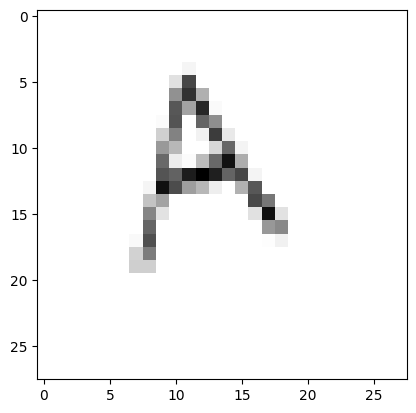

The character is probably: A


In [32]:
image_number = 1
emnist_map = [
    '0','1','2','3','4','5','6','7','8','9',
    'A','B','C','D','E','F','G','H','I','J',
    'K','L','M','N','O','P','Q','R','S','T',
    'U','V','W','X','Y','Z',
    'a','b','d','e','f','g','h','n','q','r','t'
]
while os.path.isfile(f"Character{image_number}.png"):
    try:
        img = cv2.imread(f"Character{image_number}.png")[:,:,0]
        img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)
        img = np.invert(img)
        img = img.reshape(1, 28, 28, 1)   # batch = 1 for one image, height, width, channels
        prediction = model.predict(img)
        plt.imshow(img[0], cmap = plt.cm.binary)
        plt.show()
        class_index = np.argmax(prediction)
        print(f"The character is probably: {emnist_map[class_index]}")

    except FileNotFoundError:
        print("File wasn't found")
    except IndexError:
        print("Index out of range")
    except:
        print("Unexpected error:", sys.exc_info()[0])
    finally: image_number += 1

### Edge Cases

In [29]:
image_number = 0
while os.path.isfile(f"Character_{image_number}.png"):
    try:
        img = cv2.imread(f"Character_{image_number}.png")[:,:,0]
        img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)
        img = np.invert(img)
        img = img.reshape(1, 28, 28, 1)   # batch = 1 for one image, height, width, channels
        prediction = model.predict(img)
        plt.imshow(img[0], cmap = plt.cm.binary)
        plt.show()
        print(f"The character is probably: {np.argmax(prediction)}")
    except FileNotFoundError:
        print("File wasn't found")
    except IndexError:
        print("Index out of range")
    except:
        print("Unexpected error:", sys.exc_info()[0])
    finally: image_number += 1